# Rakuten USA - Data Engineering Test

### Goal
The goal of this test is not ment to be exhaustive, but we do want to test your skills in analytical thinking, SQL, data wrangling, data analysis, and data visualization. 

**Please remember:** The better that you do on this assignment, the less questions we will have during your on-site interviews. :)

### Expectations
You can expect this test to use the following technologies:
- Python3
- Jupyter Notebook
- PySpark
- PySpark SQL

This test will cover the following areas: 
- Data Cleaning/Wrangling
- Exploratory Data Analysis (EDA)
- Data Visualization

This test should take you no more than 2-4 hours.

### What to turn in, and where to send your test
Please email stirling.waite@rakuten with your finished notebook
- rakuten_engineer_test.ipynb
 
### Questions?
Feel free to email me or call me with any questions about this test
- Email: stirling.waite@rakuten.com
- Phone: 801-856-1426
- LinkedIn Chat: https://www.linkedin.com/in/stirlingwaite/
- Gchat: stirlingw@gmail.com

# About The Dataset

Below you will find a modified free Kaggle competition dataset from https://www.kaggle.com/mayank811/employee-reviews/data using scraped data from Glassdoor.com.

## Context
- Over 67k employee reviews for Google, Amazon, Facebook, Apple, Microsoft, and Netflix.
- Web scraped from Glassdoor

## Content
This dataset contains employee reviews separated into the following categories:

- **Index:** index
- **Company:** Company name
- **Location:** This dataset is global, as such it may include the country's name in parenthesis [i.e "Toronto, ON(Canada)"]. However, if the location is in the USA then it will only include the city and state[i.e "Los Angeles, CA" ]
- **Date Posted:** in the following format MM DD, YYYY
- **Job-Title:** This string will also include whether the reviewer is a 'Current' or 'Former' Employee at the time of the review
- **Summary:** Short summary of employee review
- **Pros:** Pros
- **Cons:** Cons
- **Overall Rating:** 1-5
- **Work/Life Balance Rating:** 1-5
- **Culture and Values Rating:** 1-5
- **Career Opportunities Rating:** 1-5
- **Comp & Benefits Rating:** 1-5
- **Senior Management Rating:** 1-5
- **Helpful Review Count:** 1-5

**Link to Review:** This will provide you with a direct link to the page that contains the review. However it is likely that this link will be outdated

**NOTE:** 'none' is placed in all cells where no data value was found.



# PySpark Initialization

In [1]:
import findspark
findspark.init()
import re
import pyspark
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql import functions as fn
from pyspark.sql import types as t
from pyspark.sql.types import *
from datetime import datetime

In [2]:
conf = SparkConf()\
                .setMaster("local[*]")\
                .setAppName("rakutenHomework")
        
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

## Read Dataset into Spark

In [3]:
reviews_df = spark.read.csv("employee_reviews_usa.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
print(reviews_df.count())
reviews_df.show()

28357
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|_c0|company|         location|        dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|  0| google|Mountain View, CA|  Feb 8, 2015|Current Employee

In [4]:
# Viewing sample in a via pandas

reviews_df.limit(5).toPandas().head(5)

,_c0,company,location,dates,job_title,summary,pros,cons,advice_to_mgmt,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,link
0,0,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
1,1,google,"Mountain View, CA","Dec 9, 2018",Former Employee - SDE2,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,none,5.0,4.0,4.0,4.0,5.0,4.0,1,https://www.glassdoor.com/Reviews/Google-Revie...
2,2,google,"New York, NY","Dec 11, 2018",Current Employee - Software Engineer,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,none,5.0,5.0,4.0,4.0,5.0,4.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
3,3,google,"New York, NY","Dec 10, 2018",Current Employee - Anonymous Employee,Google Surpasses Realistic Expectations,Great products. Vision you can feel good about...,Younger employees complaining about the compan...,none,5.0,5.0,5.0,5.0,5.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
4,4,google,"Mountain View, CA","Dec 8, 2018",Current Employee - Anonymous Employee,Nice place to work,* Smart people * World class infrastructure * ...,Giant company with uneven project and team cha...,none,5.0,4.0,5.0,4.0,4.0,3.0,0,https://www.glassdoor.com/Reviews/Google-Revie...


In [5]:
# What are data types here? 

reviews_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- company: string (nullable = true)
 |-- location: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- pros: string (nullable = true)
 |-- cons: string (nullable = true)
 |-- advice_to_mgmt: string (nullable = true)
 |-- overall_ratings: string (nullable = true)
 |-- work_balance_stars: string (nullable = true)
 |-- culture_values_stars: string (nullable = true)
 |-- carrer_opportunities_stars: string (nullable = true)
 |-- comp_benefit_stars: string (nullable = true)
 |-- senior_mangemnet_stars: string (nullable = true)
 |-- helpful_count: string (nullable = true)
 |-- link: string (nullable = true)



All the columns are strings except for index.Even the ratings, such as `overall_ratings`,`work_balance_stars`,`culture_values_starts`,`career_opportunities_stars`,`comp_benefit_stars`,`helpful_count` which could take int formats are strings here

In [6]:
# lets check if there are nulls in here

reviews_df.select([count(when(isnan(c), c)).alias(c) for c in reviews_df.columns]).toPandas()

,_c0,company,location,dates,job_title,summary,pros,cons,advice_to_mgmt,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,link
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No null values observed in the dataframe

In [7]:
# How big the the data set?

print((reviews_df.count(), len(reviews_df.columns)))

(28357, 17)


In [8]:
# Summary stats

reviews_df.describe().toPandas()

,summary,_c0,company,location,dates,job_title,summary,pros,cons,advice_to_mgmt,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,link
0,count,27779,27779,27779,27779,27779,27757,27779,27779,27779,27779,27779,27779,27779,27779,27779,27779,27779
1,mean,14147.457287879333,None,None,None,None,33193.4,None,None,None,3.7785737427553188,3.3734953271028036,3.7328037709497206,3.617313734290844,3.9743589743589745,3.300279013649046,1.485114654955182,None
2,stddev,8182.533708216518,None,None,None,None,45340.723409535494,None,None,None,1.1737432572393722,1.2936159800713927,1.320662779118574,1.2356798279013699,1.0224265472011032,1.3248882619778573,14.527349003372983,None
3,min,0,amazon,"Aberdeen, MD","Apr 1, 2009","Current Employee - &#039,Anonymous&#039,",#1 Comapny for Innovation,"""""""""""""""Amazon"""""""" looks good on your resume SL...","""""""""""""""Always On"""""""" mentality-you could work ...","""""""""""""""Inclusion"""""""" aka diversity means more ...",1.0,1.0,1.0,1.0,1.0,1.0,0,https://www.glassdoor.com/Reviews/Amazon-Revie...
4,max,28356,netflix,"Yukon, OK","Sep 9, 2018",Former Employee - eot,🔥,• Treated fairly • Great co-workers • Dedicati...,"• The company culture is very cold hearted, t...",• stop being selfish and develop a team approa...,5.0,none,none,none,none,none,9,https://www.glassdoor.com/Reviews/Netflix-Revi...


# Data Cleaning & Removing Un-Needed Columns

No one likes dirty data.  Let's clean up this dataset to make it more usable for our use case.

 
1. Make the date field more data friendly
    - Hint #1: Use the provided `review_date_udf` udf provided (it will make your life more simple) 
2. Using the "location" column 
    - Add new columns for city, state, country columns
        - Hint #1: Concider using `fn.split()` to split `location` for columns `city` `state` 
        - Hint #2: I've narrowed down the country to just US, so please use something like below to create the `country` column
            - ```lit("US").alias("country")```
3. Using the "job-title" column  
    - Add a new boolean column titled "current_employee" that will show:
        - 1,  if reviewer is a current employee
        - 0,  if reviewer is not a current employee
        - Hint:  Use spark function `fn.when()` and `col("job-title").contains("")`
    - Remove "Former Employee - " and "" from the "job-title" column
        - Hint: Use the udf function `reg_job_title_udf`
4. Drop un-needed columns 
    - "_c0", "link", "pros", "cons", "advice-to-mgmt", "summary", "location"

##### Useful UDF functions needed for below

In [9]:
review_date_udf = fn.udf(
    lambda x: datetime.strptime(x, ' %b %d, %Y'), DateType()
)

In [10]:
def reg_job_title(column):
    res_split=[]
    reg_patterns=["Former Employee - / ", "Current Employee - / "]
    for i in range(len(reg_patterns)):
        res_split=re.findall(r"[^/]+",reg_patterns[i])
        for x in res_split[0].split("|"):
            column = column.replace(x,res_split[1])
    return column[1:]

reg_job_title_udf = fn.udf(reg_job_title, t.StringType())

# Cleaned Spark Dataframe

- I've included the starting of dataframe, but in the `select` you will want to add the fixes and columns needed to answer the questions below


In [11]:
reviews_df.limit(5).toPandas().head(5)

,_c0,company,location,dates,job_title,summary,pros,cons,advice_to_mgmt,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count,link
0,0,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
1,1,google,"Mountain View, CA","Dec 9, 2018",Former Employee - SDE2,NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice to ...",Food is not good as I expected. People said it...,none,5.0,4.0,4.0,4.0,5.0,4.0,1,https://www.glassdoor.com/Reviews/Google-Revie...
2,2,google,"New York, NY","Dec 11, 2018",Current Employee - Software Engineer,Software engineer,Great working environment. Good work life balance,Usual big company problems. Hierarchy.,none,5.0,5.0,4.0,4.0,5.0,4.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
3,3,google,"New York, NY","Dec 10, 2018",Current Employee - Anonymous Employee,Google Surpasses Realistic Expectations,Great products. Vision you can feel good about...,Younger employees complaining about the compan...,none,5.0,5.0,5.0,5.0,5.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
4,4,google,"Mountain View, CA","Dec 8, 2018",Current Employee - Anonymous Employee,Nice place to work,* Smart people * World class infrastructure * ...,Giant company with uneven project and team cha...,none,5.0,4.0,5.0,4.0,4.0,3.0,0,https://www.glassdoor.com/Reviews/Google-Revie...


In [12]:
cleaned_reviews_df = reviews_df.where((col("dates") != 'None') & (col("dates") != ' Jan 0, 0000') & (col("dates") != ' Nov 0, 0000') & (~col("location").contains("(")) & (col("location") != "none")) \
                         .select(
                             col("company")
                            , fn.trim(fn.split(reviews_df.location,',')[0]).alias('city')
                            , fn.trim(fn.split(reviews_df.location,',')[1]).alias('state')
                            , lit("US").alias("country")
                            , review_date_udf(reviews_df.dates).alias('review_date')
                            , reg_job_title_udf(reviews_df.job_title).alias('job_title')
                            , fn.when(lower(col("job_title")).contains('current'), 1).otherwise(0).alias('current_employee')
                            , col("overall_ratings").cast("float")
                            , col("work_balance_stars").cast("float")
                            , col("culture_values_stars").cast("float")
                            , col("carrer_opportunities_stars").cast("float")
                            , col("comp_benefit_stars").cast("float")
                            , col("senior_mangemnet_stars").cast("float")
                            , col("helpful_count").cast("float"))
                         
cleaned_reviews_df.toPandas().head(5)


,company,city,state,country,review_date,job_title,current_employee,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count
0,google,Mountain View,CA,US,2015-02-08,Anonymous Employee,1,5.0,2.0,5.0,5.0,4.0,5.0,498.0
1,google,Mountain View,CA,US,2018-12-09,SDE2,0,5.0,4.0,4.0,4.0,5.0,4.0,1.0
2,google,New York,NY,US,2018-12-11,Software Engineer,1,5.0,5.0,4.0,4.0,5.0,4.0,0.0
3,google,New York,NY,US,2018-12-10,Anonymous Employee,1,5.0,5.0,5.0,5.0,5.0,5.0,0.0
4,google,Mountain View,CA,US,2018-12-08,Anonymous Employee,1,5.0,4.0,5.0,4.0,4.0,3.0,0.0


# Data Questions

Each question below will have two parts.   Please solve each problem in PySpark and PySpark SQL.  This is to test your ability to solve the problem in PySpark, and to test your ability to solve the problem in SQL.

- PySpark API (https://spark.apache.org/docs/latest/api/python/index.html)
- PySpark SQL API (https://spark.apache.org/docs/latest/api/python/pyspark.sql.html)

In [13]:
cleaned_reviews_df.createOrReplaceTempView("reviews")

### (1) What is the total number of reviews in the data set?

##### PySpark Implmentation

In [14]:
cleaned_reviews_df.count()

28357

##### Spark SQL Implmentation

In [15]:
spark.sql("select count(*) as review_count from reviews").show()

+------------+
|review_count|
+------------+
|       28357|
+------------+



###  (2) How many reviews exist in the dataset per each company?

##### PySpark Implmentation

In [16]:
cleaned_reviews_df.groupby(cleaned_reviews_df["company"]).count().show()

+---------+-----+
|  company|count|
+---------+-----+
|microsoft| 8114|
|   amazon|10164|
|  netflix|  458|
|    apple| 5853|
| facebook| 1167|
|   google| 2601|
+---------+-----+



##### Spark SQL Implmentation

In [17]:
spark.sql("select company, count(*) as review_count from reviews group by company").show()

+---------+------------+
|  company|review_count|
+---------+------------+
|microsoft|        8114|
|   amazon|       10164|
|  netflix|         458|
|    apple|        5853|
| facebook|        1167|
|   google|        2601|
+---------+------------+



###  (3) How many reviews are from former and current employees per each company?

##### PySpark Implmentation

In [18]:
cleaned_reviews_df.crosstab('company','current_employee').sort(col("company_current_employee").asc()).show()

+------------------------+----+----+
|company_current_employee|   0|   1|
+------------------------+----+----+
|                  amazon|3410|6754|
|                   apple|2445|3408|
|                facebook| 222| 945|
|                  google| 946|1655|
|               microsoft|2865|5249|
|                 netflix| 223| 235|
+------------------------+----+----+



##### Spark SQL Implmentation

In [19]:
spark.sql("""select company, 
          current_employee from reviews
          order by company
          """).groupBy("company").pivot("current_employee").count().show()

+---------+----+----+
|  company|   0|   1|
+---------+----+----+
|   amazon|3410|6754|
|    apple|2445|3408|
| facebook| 222| 945|
|   google| 946|1655|
|microsoft|2865|5249|
|  netflix| 223| 235|
+---------+----+----+



###  (4) What is the average review scores of each current and former employees for each company?

##### PySpark Implmentation

In [20]:
avg_review_scores = cleaned_reviews_df.groupby(cleaned_reviews_df.company).pivot("current_employee").avg("overall_ratings")
avg_review_scores.select(col("company"), fn.round('1', 2).alias('current_employee'), 
                         fn.round('0', 2).alias('former_employee')).sort(col("company").asc()).show()


+---------+----------------+---------------+
|  company|current_employee|former_employee|
+---------+----------------+---------------+
|   amazon|            3.71|           2.98|
|    apple|            4.08|           3.83|
| facebook|             4.7|           3.93|
|   google|            4.43|           4.16|
|microsoft|            3.86|           3.56|
|  netflix|            3.97|           2.94|
+---------+----------------+---------------+



##### Spark SQL Implmentation

In [21]:
spark.sql("""select company, 
          current_employee,
          overall_ratings from reviews
          """).groupBy("company").pivot("current_employee").avg("overall_ratings").select(col("company")
                                                                                          ,fn.round('1', 2).alias('current_employee')
                                                                                          ,fn.round('0', 2).alias('former_employee')
                                                                                          ).sort(col("company").asc()).show()




+---------+----------------+---------------+
|  company|current_employee|former_employee|
+---------+----------------+---------------+
|   amazon|            3.71|           2.98|
|    apple|            4.08|           3.83|
| facebook|             4.7|           3.93|
|   google|            4.43|           4.16|
|microsoft|            3.86|           3.56|
|  netflix|            3.97|           2.94|
+---------+----------------+---------------+



###  (5) Show the count of former Google employee reviews and the average work_balance_score ONLY for locations in Seattle, San Francisco, or Utah
- Please show in one solution  
- Hint:  Since you already broke out the location to city, state, country in the data wrangling phase above you can use the city and state columns in your where statement

##### PySpark Implmentation

In [22]:
cleaned_reviews_df.where((col("company") == 'google') & \
                         (col("current_employee") == 0) & \
                         ((col("city").isin('Seattle','San Francisco')) |
                         (col("state").isin('UT')))).groupby() \
                        .agg(count("*").alias("total_former_googler_reviews_in_sf_sea_ut") \
                       , fn.round(avg("work_balance_stars"), 2).alias("avg_work_balance_stars")).show()

+-----------------------------------------+----------------------+
|total_former_googler_reviews_in_sf_sea_ut|avg_work_balance_stars|
+-----------------------------------------+----------------------+
|                                       92|                  4.19|
+-----------------------------------------+----------------------+



##### Spark SQL Implmentation

In [23]:
spark.sql("""select count(*) as total_former_googler_reviews_in_sf_sea_ut
    , round(avg(work_balance_stars), 2) as avg_work_balance_stars
    from reviews 
    where company = 'google'
    and current_employee = 0
    and (lower(city) in ('seattle','san francisco')
    or state == 'UT')""").show()

+-----------------------------------------+----------------------+
|total_former_googler_reviews_in_sf_sea_ut|avg_work_balance_stars|
+-----------------------------------------+----------------------+
|                                       92|                  4.19|
+-----------------------------------------+----------------------+



# Data Visualization
1. Turn your Spark dataframe into a Pandas dataframe
    - https://pandas.pydata.org/
2. Answer the visualization questions with any of the following libraries:
    - Matplotlib (https://matplotlib.org/)
    - Seaborn (https://seaborn.pydata.org/introduction.html)
    - Bookeh (https://bokeh.pydata.org/en/latest/)

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [25]:
reviews_pd_df = cleaned_reviews_df.toPandas()
reviews_pd_df.head()

,company,city,state,country,review_date,job_title,current_employee,overall_ratings,work_balance_stars,culture_values_stars,carrer_opportunities_stars,comp_benefit_stars,senior_mangemnet_stars,helpful_count
0,google,Mountain View,CA,US,2015-02-08,Anonymous Employee,1,5.0,2.0,5.0,5.0,4.0,5.0,498.0
1,google,Mountain View,CA,US,2018-12-09,SDE2,0,5.0,4.0,4.0,4.0,5.0,4.0,1.0
2,google,New York,NY,US,2018-12-11,Software Engineer,1,5.0,5.0,4.0,4.0,5.0,4.0,0.0
3,google,New York,NY,US,2018-12-10,Anonymous Employee,1,5.0,5.0,5.0,5.0,5.0,5.0,0.0
4,google,Mountain View,CA,US,2018-12-08,Anonymous Employee,1,5.0,4.0,5.0,4.0,4.0,3.0,0.0


### Plot the distributions of reviews for each company (current and former employees) 
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot
    

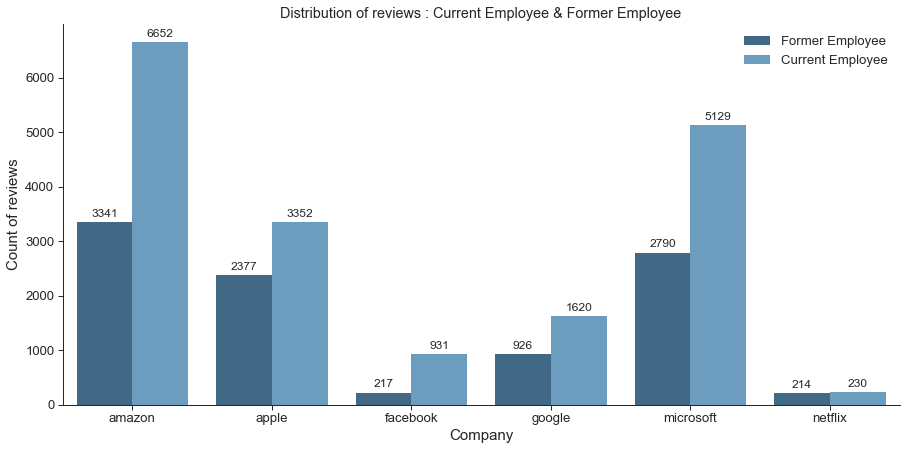

In [26]:
viz_df = reviews_pd_df[['company','current_employee','overall_ratings']].groupby(['company','current_employee']).count().reset_index()

## Styling 
plt.figure(figsize = (15, 7))
plt.style.use('seaborn-white')
sns.set_context("paper", font_scale=1.5, rc={"font.size":10,"axes.labelsize":15})

ax = sns.barplot(x='company',y='overall_ratings'
                 , data = viz_df , hue = 'current_employee', palette = 'Blues_d')
ax.set_ylabel('Count of reviews')
ax.set_xlabel('Company')
ax.set_title('Distribution of reviews : Current Employee & Former Employee')
for t, l in zip(ax.get_legend().texts, ['Former Employee','Current Employee']): t.set_text(l)
ax.get_legend().set_title('')
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2., height + 100, 
           '{}'.format(int(100 * height / 100)),
           ha = 'center' ,fontsize = 12)


sns.despine()


### Plot the distributions of reviews for each company (current and former employees) and their overall ratings
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot

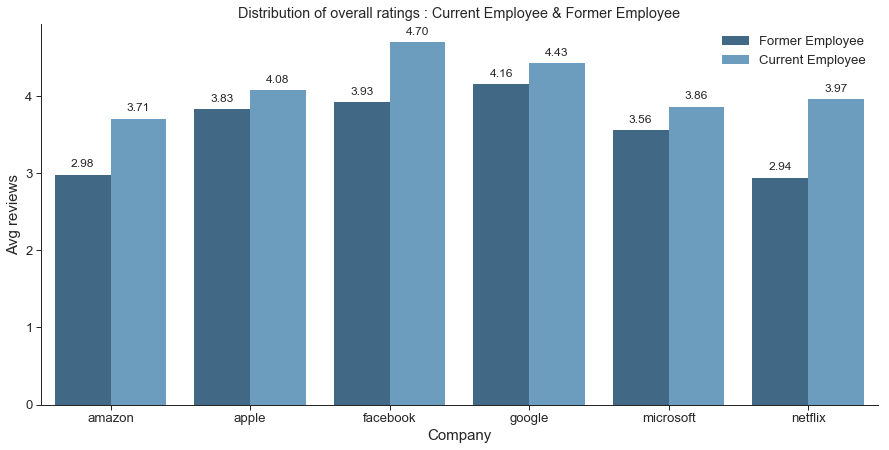

In [27]:
viz_df = reviews_pd_df[['company','current_employee','overall_ratings']].groupby(['company','current_employee']).mean().reset_index()

## Styling 
plt.figure(figsize = (15, 7))
plt.style.use('seaborn-white')
sns.set_context("paper", font_scale=1.5, rc={"font.size":10,"axes.labelsize":15})

ax = sns.barplot(x='company',y='overall_ratings'
                 , data = viz_df , hue = 'current_employee', palette = 'Blues_d')
ax.set_ylabel('Avg reviews')
ax.set_xlabel('Company')
ax.set_title('Distribution of overall ratings : Current Employee & Former Employee')
for t, l in zip(ax.get_legend().texts, ['Former Employee','Current Employee']): t.set_text(l)
ax.get_legend().set_title('')
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2., height + 0.1, 
           '{:1.2f}'.format(100 * height / 100),
           ha = 'center' ,fontsize = 12)


sns.despine()


# Lessons Learned
- Please feel free to let us know anything you want in this section about the test, what you learned, liked, didn't like, etc

This is an interesting assignment with most frequently used transformations in data wrangling.Thanks for the clear instructions on installing spark. I learnt about a library today `findspark`, which helped me to fix missing `py4j` error pretty quickly. 

In [28]:
pwd

'/Users/mdobbali/Documents/rakutenusadataengineeringtest'